### Capstone 1: White Wine Quality, UC Irvine
(Source: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009)

# 2. Linear Regression

### Outliers Removed, Categories Balanced

#### Audrey Hughes Rager
#### March 3, 2021


## Import Packages

In [92]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.stats.weightstats as smsw
import pylab

# Import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
#from sklearn import cross_validation
from scipy import stats as st
import warnings 
warnings.filterwarnings('ignore')

#Import Imbalanced Learn
from imblearn.over_sampling import RandomOverSampler

# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')


<h2>Data Wrangling</h2>

In [93]:
#Import csv files into Pandas data frames
#reddf = pd.read_csv('winequality-red.csv',sep=";")
#whitedf = pd.read_csv('winequality-white.csv',sep=";")
df = pd.read_csv('winequality-white-outliers-removed.csv',sep=";")
df = df.rename({'fixed acidity': 'fixed_acidity','volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar':'residual_sugar',  'free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide'}, axis=1)

df.describe()


,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000
mean,2509.315363,6.809048,0.263828,0.322749,6.352759,0.042299,34.730575,136.953176,0.993844,3.189043,0.481445,10.592035,5.953936
std,1414.165983,0.726417,0.076298,0.083076,4.905477,0.009889,14.941739,41.049024,0.002877,0.137980,0.098904,1.214421,0.856194
min,0.000000,4.900000,0.080000,0.110000,0.600000,0.016000,2.000000,19.000000,0.987110,2.830000,0.220000,8.400000,3.000000
25%,1269.000000,6.300000,0.210000,0.270000,1.800000,0.035000,24.000000,107.000000,0.991580,3.100000,0.410000,9.500000,5.000000
50%,2588.000000,6.800000,0.260000,0.310000,5.200000,0.042000,34.000000,132.000000,0.993520,3.180000,0.470000,10.500000,6.000000
75%,3731.500000,7.300000,0.310000,0.370000,9.600000,0.049000,45.000000,166.000000,0.995870,3.280000,0.540000,11.400000,6.000000
max,4897.000000,8.700000,0.485000,0.540000,20.800000,0.071000,78.000000,253.000000,1.001960,3.570000,0.760000,14.200000,9.000000


<h2>Identifying and Removing Outliers</h2>
<p>A predictor variable is considered to be an outlier only if it is > Q<sub>3</sub> + 1.5 IQR. Because all skewed data are positively skewed, we only need to eliminate those values.</p>

In [94]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
ValueList = ('fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
            'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol')

for myValue in ValueList:
    #compute range of data
    myValueMax = df[myValue].max()
    myValueMin = df[myValue].min()
    myValueRange = myValueMax - myValueMin
    
    # Computing IQR
    Q1 = df[myValue].quantile(0.25)
    Q3 = df[myValue].quantile(0.75)
    IQR = Q3 - Q1
    gtdropvalue = (Q3 + (1.5 * IQR))
    ltdropvalue = (Q1 - (1.5 * IQR))
    
    index_names_right = df[df[myValue] >= gtdropvalue].index
    index_names_left = df[df[myValue] <= ltdropvalue].index
    df.drop(index_names_right, inplace = True)
    df.drop(index_names_left, inplace = True)
    
    
   

In [95]:
df.describe()

,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000
mean,2506.943336,6.809936,0.261729,0.320564,6.344227,0.042298,34.605347,136.577946,0.993824,3.188606,0.477667,10.599330,5.959564
std,1413.814206,0.723280,0.073239,0.079510,4.904316,0.009842,14.713299,40.783830,0.002862,0.136200,0.094768,1.210461,0.849483
min,0.000000,4.900000,0.080000,0.130000,0.600000,0.016000,2.000000,21.000000,0.987110,2.840000,0.220000,8.400000,3.000000
25%,1272.500000,6.300000,0.210000,0.270000,1.800000,0.035000,24.000000,107.000000,0.991565,3.100000,0.410000,9.500000,5.000000
50%,2588.000000,6.800000,0.260000,0.310000,5.200000,0.042000,34.000000,132.000000,0.993500,3.180000,0.470000,10.500000,6.000000
75%,3723.500000,7.300000,0.310000,0.370000,9.575000,0.049000,45.000000,165.000000,0.995810,3.280000,0.540000,11.400000,6.000000
max,4897.000000,8.700000,0.450000,0.510000,20.800000,0.069000,76.000000,251.000000,1.001960,3.540000,0.730000,14.200000,9.000000


### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [96]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [97]:
sm.__version__

'0.12.0'

## Model 1


In [98]:
#Create y and X datasets for this model
ym1 = df.quality
Xm1 = df.drop(['quality'],axis=1)
#Balance data
ros = RandomOverSampler(random_state=42)
Xm1_resampled, ym1_resampled = ros.fit_resample(Xm1, ym1)
from collections import Counter
print(sorted(Counter(ym1_resampled).items()))

from sklearn.model_selection import train_test_split
Xm1_train, Xm1_test, ym1_train, ym1_test = train_test_split(Xm1_resampled, ym1_resampled, test_size=0.25, random_state=101)
Xm1_train.head()

[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
3016,3967,6.3,0.27,0.51,7.6,0.049,35.0,200.0,0.99548,3.16,0.54,9.4
1981,2718,5.2,0.28,0.29,1.1,0.028,18.0,69.0,0.99168,3.24,0.54,10.0
9700,2804,6.4,0.22,0.32,7.2,0.028,15.0,83.0,0.99300,3.13,0.55,10.9
5229,3087,6.1,0.20,0.34,9.5,0.041,38.0,201.0,0.99500,3.14,0.44,10.1
2351,3160,6.5,0.34,0.46,1.0,0.023,6.0,80.0,0.98865,3.15,0.54,12.9


In [99]:
Xm1_train.shape

(9313, 12)

In [100]:
from sklearn.linear_model import LinearRegression
lm1 = LinearRegression()
lm1.fit(Xm1_train,ym1_train)
print('Estimated intercept coefficient:',lm1.intercept_)
print ('Number of coefficients:', len(lm1.coef_))
coeffm1_df = pd.DataFrame(lm1.coef_,Xm1.columns,columns=['Coefficient'])
coeffm1_df

Estimated intercept coefficient: 406.15811821987677
Number of coefficients: 12


,Coefficient
Unnamed: 0,-0.000084
fixed_acidity,0.525489
volatile_acidity,-2.988044
citric_acid,-2.862851
residual_sugar,0.133560
chlorides,-33.010459
free_sulfur_dioxide,0.045759
total_sulfur_dioxide,0.000272
density,-411.495138
pH,0.808531


In [101]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
ym1, Xm1 = dmatrices('quality ~ fixed_acidity+volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+density+pH+sulphates+alcohol', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vifm1 = pd.DataFrame()
vifm1['VIF'] = [variance_inflation_factor(Xm1.values, i) for i in range(Xm1.shape[1])]
vifm1['variable'] = Xm1.columns

#view VIF for each explanatory variable 
vifm1

,VIF,variable
0,5.594502e+06,Intercept
1,2.922610e+00,fixed_acidity
2,1.150645e+00,volatile_acidity
3,1.122511e+00,citric_acid
4,1.875046e+01,residual_sugar
5,1.562118e+00,chlorides
6,1.826980e+00,free_sulfur_dioxide
7,2.476600e+00,total_sulfur_dioxide
8,4.703059e+01,density
9,2.314887e+00,pH


In [102]:
predictions_m1 = lm1.predict(Xm1_test)

**Predicted vs. Actual**

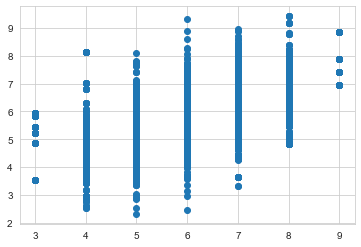

In [103]:
plt.scatter(ym1_test,predictions_m1)

**Residual Histogram**

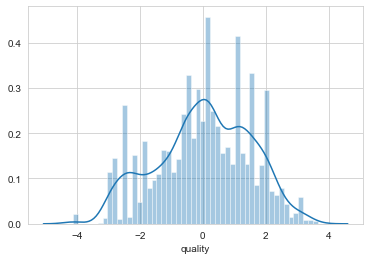

In [104]:
sns.distplot((ym1_test-predictions_m1),bins=50);

In [105]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym1_test, predictions_m1))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym1_test, predictions_m1))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym1_test, predictions_m1)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym1_test, predictions_m1))
print('Explained Variance:', metrics.explained_variance_score(ym1_test, predictions_m1))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym1_test, predictions_m1))
print('Median Absolute Error:', metrics.median_absolute_error(ym1_test, predictions_m1))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym1_test, predictions_m1))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym1_test, predictions_m1))



R-squared: 0.43815915131576644
Mean Squared Error (MSE): 2.222735703177442
Root Mean Squared Error (RMSE): 1.4908842018002075
Log Mean Squared Error: 0.05735555042294738
Explained Variance: 0.43830930680297064
Mean Absolute Error (MAE): 1.210796255079032
Median Absolute Error: 1.126267084715039
Poisson Deviance: 0.4071261815520715
Mean Gamma Deviance: 0.0789072128858156


## Model 2 -  Drop Density For High VIF

In [106]:
#Create y and X datasets for this model
ym2 = df.quality
Xm2 = df.drop(['quality','density'],axis=1)
#Balance data
ros = RandomOverSampler(random_state=42)
Xm2_resampled, ym2_resampled = ros.fit_resample(Xm2, ym2)
from collections import Counter
print(sorted(Counter(ym2_resampled).items()))

from sklearn.model_selection import train_test_split
Xm2_train, Xm2_test, ym2_train, ym2_test = train_test_split(Xm2_resampled, ym2_resampled, test_size=0.25, random_state=101)
Xm2_train.head()

[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol
3016,3967,6.3,0.27,0.51,7.6,0.049,35.0,200.0,3.16,0.54,9.4
1981,2718,5.2,0.28,0.29,1.1,0.028,18.0,69.0,3.24,0.54,10.0
9700,2804,6.4,0.22,0.32,7.2,0.028,15.0,83.0,3.13,0.55,10.9
5229,3087,6.1,0.20,0.34,9.5,0.041,38.0,201.0,3.14,0.44,10.1
2351,3160,6.5,0.34,0.46,1.0,0.023,6.0,80.0,3.15,0.54,12.9


In [107]:
from sklearn.linear_model import LinearRegression
lm2 = LinearRegression()
lm2.fit(Xm2_train,ym2_train)
print('Estimated intercept coefficient:',lm2.intercept_)
print ('Number of coefficients:', len(lm2.coef_))
coeffm2_df = pd.DataFrame(lm2.coef_,Xm2.columns,columns=['Coefficient'])
coeffm2_df

Estimated intercept coefficient: -0.6101522829329129
Number of coefficients: 11


,Coefficient
Unnamed: 0,-0.000095
fixed_acidity,0.209322
volatile_acidity,-2.987791
citric_acid,-3.101458
residual_sugar,-0.002575
chlorides,-39.841435
free_sulfur_dioxide,0.049918
total_sulfur_dioxide,-0.001993
pH,-0.292769
sulphates,3.098249


In [108]:
predictions_m2 = lm2.predict(Xm2_test)

**Predicted vs. Actual**

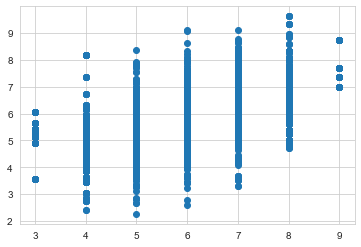

In [109]:
plt.scatter(ym2_test,predictions_m2)

**Residual Histogram**

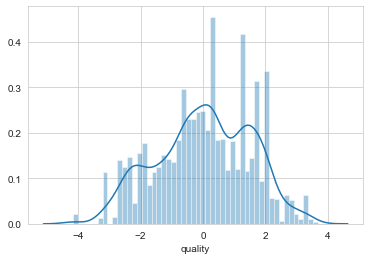

In [110]:
sns.distplot((ym2_test-predictions_m2),bins=50);

In [111]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym2_test, predictions_m2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym2_test, predictions_m2))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym2_test, predictions_m2)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym2_test, predictions_m2))
print('Explained Variance:', metrics.explained_variance_score(ym2_test, predictions_m2))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym2_test, predictions_m2))
print('Median Absolute Error:', metrics.median_absolute_error(ym2_test, predictions_m2))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym2_test, predictions_m2))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym2_test, predictions_m2))



R-squared: 0.4311699190371373
Mean Squared Error (MSE): 2.250386266784362
Root Mean Squared Error (RMSE): 1.5001287500692606
Log Mean Squared Error: 0.057538818032359745
Explained Variance: 0.4313221629800107
Mean Absolute Error (MAE): 1.2293645938991309
Median Absolute Error: 1.1835228345847595
Poisson Deviance: 0.4109287402313646
Mean Gamma Deviance: 0.07951922255824746


In [112]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
ym2, Xm2 = dmatrices('quality ~ fixed_acidity+volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+pH+sulphates+alcohol', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vifm2 = pd.DataFrame()
vifm2['VIF'] = [variance_inflation_factor(Xm2.values, i) for i in range(Xm2.shape[1])]
vifm2['variable'] = Xm2.columns

#view VIF for each explanatory variable 
vifm2

,VIF,variable
0,1230.869516,Intercept
1,1.277560,fixed_acidity
2,1.148697,volatile_acidity
3,1.116169,citric_acid
4,1.525892,residual_sugar
5,1.504576,chlorides
6,1.765687,free_sulfur_dioxide
7,2.297958,total_sulfur_dioxide
8,1.241939,pH
9,1.053502,sulphates


## Backward Elimination Method to create subsequent models

## Model 3: Drop Total Sulfur Dioxide


In [113]:
#Create y and X datasets for this model
ym3 = df.quality
Xm3 = df.drop(['quality','density','total_sulfur_dioxide'],axis=1)
#Balance data
ros = RandomOverSampler(random_state=42)
Xm3_resampled, ym3_resampled = ros.fit_resample(Xm3, ym3)
from collections import Counter
print(sorted(Counter(ym3_resampled).items()))

from sklearn.model_selection import train_test_split
Xm3_train, Xm3_test, ym3_train, ym3_test = train_test_split(Xm3_resampled, ym3_resampled, test_size=0.25, random_state=101)
Xm3_train.head()

[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,pH,sulphates,alcohol
3016,3967,6.3,0.27,0.51,7.6,0.049,35.0,3.16,0.54,9.4
1981,2718,5.2,0.28,0.29,1.1,0.028,18.0,3.24,0.54,10.0
9700,2804,6.4,0.22,0.32,7.2,0.028,15.0,3.13,0.55,10.9
5229,3087,6.1,0.20,0.34,9.5,0.041,38.0,3.14,0.44,10.1
2351,3160,6.5,0.34,0.46,1.0,0.023,6.0,3.15,0.54,12.9


In [114]:
Xm3_train.shape

(9313, 10)

In [115]:
from sklearn.linear_model import LinearRegression
lm3 = LinearRegression()
lm3.fit(Xm3_train,ym3_train)
print('Estimated intercept coefficient:',lm3.intercept_)
print ('Number of coefficients:', len(lm3.coef_))
coeffm1_df = pd.DataFrame(lm3.coef_,Xm3.columns,columns=['Coefficient'])
coeffm1_df

Estimated intercept coefficient: -0.7192496107821569
Number of coefficients: 10


,Coefficient
Unnamed: 0,-0.000094
fixed_acidity,0.207805
volatile_acidity,-3.044810
citric_acid,-3.236195
residual_sugar,-0.004043
chlorides,-40.905201
free_sulfur_dioxide,0.047306
pH,-0.340141
sulphates,3.054180
alcohol,0.657805


In [116]:
predictions_m3 = lm3.predict(Xm3_test)

**Predicted vs. Actual**

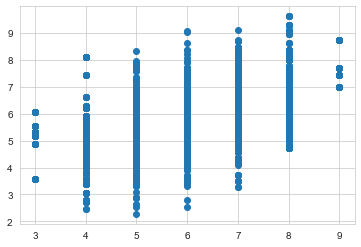

In [117]:
plt.scatter(ym3_test,predictions_m3)

**Residual Histogram**

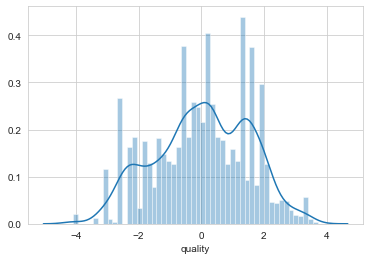

In [118]:
sns.distplot((ym3_test-predictions_m3),bins=50);

In [119]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym3_test, predictions_m3))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym3_test, predictions_m3))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym3_test, predictions_m3)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym3_test, predictions_m3))
print('Explained Variance:', metrics.explained_variance_score(ym3_test, predictions_m3))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym3_test, predictions_m3))
print('Median Absolute Error:', metrics.median_absolute_error(ym3_test, predictions_m3))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym3_test, predictions_m3))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym3_test, predictions_m3))



R-squared: 0.4308923072851524
Mean Squared Error (MSE): 2.2514845449786294
Root Mean Squared Error (RMSE): 1.5004947667281714
Log Mean Squared Error: 0.05766377549802383
Explained Variance: 0.43105156264815325
Mean Absolute Error (MAE): 1.2317298872330238
Median Absolute Error: 1.1835760694380815
Poisson Deviance: 0.4115960582864346
Mean Gamma Deviance: 0.07973429259945139


## Model 4: Drop Free Sulfur Dioxide

In [120]:
#Create y and X datasets for this model
ym4 = df.quality
Xm4 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide'],axis=1)
#Balance data
ros = RandomOverSampler(random_state=42)
Xm4_resampled, ym4_resampled = ros.fit_resample(Xm4, ym4)
from collections import Counter
print(sorted(Counter(ym4_resampled).items()))

from sklearn.model_selection import train_test_split
Xm4_train, Xm4_test, ym4_train, ym4_test = train_test_split(Xm4_resampled, ym4_resampled, test_size=0.25, random_state=101)
Xm4_train.head()

[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,pH,sulphates,alcohol
3016,3967,6.3,0.27,0.51,7.6,0.049,3.16,0.54,9.4
1981,2718,5.2,0.28,0.29,1.1,0.028,3.24,0.54,10.0
9700,2804,6.4,0.22,0.32,7.2,0.028,3.13,0.55,10.9
5229,3087,6.1,0.20,0.34,9.5,0.041,3.14,0.44,10.1
2351,3160,6.5,0.34,0.46,1.0,0.023,3.15,0.54,12.9


In [121]:
Xm4_train.shape

(9313, 9)

In [122]:
lm4 = LinearRegression()
lm4.fit(Xm4_train,ym4_train)
print('Estimated intercept coefficient:',lm4.intercept_)
print ('Number of coefficients:', len(lm4.coef_))
coeffm4_df = pd.DataFrame(lm4.coef_,Xm4.columns,columns=['Coefficient'])
coeffm4_df

Estimated intercept coefficient: 1.28189555235795
Number of coefficients: 9


,Coefficient
Unnamed: 0,-0.000066
fixed_acidity,0.124146
volatile_acidity,-3.479933
citric_acid,-2.469507
residual_sugar,0.057619
chlorides,-48.622521
pH,-0.528842
sulphates,3.572917
alcohol,0.674631


In [123]:
predictions_m4 = lm4.predict(Xm4_test)

**Predicted vs. Actual**

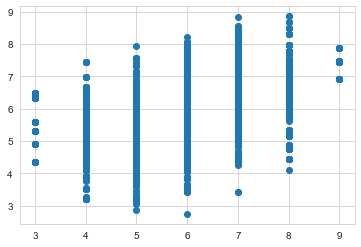

In [124]:
plt.scatter(ym1_test,predictions_m4)

**Residual Histogram**

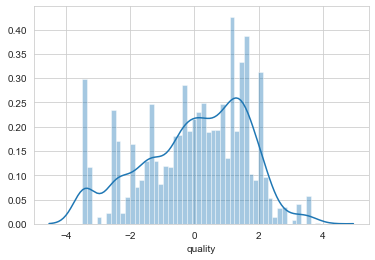

In [125]:
sns.distplot((ym4_test-predictions_m4),bins=50);

## Model 5: Drop Fixed Acidity


In [126]:
#Create y and X datasets for this model
ym5 = df.quality
Xm5 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity'],axis=1)
#Balance data
ros = RandomOverSampler(random_state=42)
Xm5_resampled, ym5_resampled = ros.fit_resample(Xm5, ym5)
from collections import Counter
print(sorted(Counter(ym5_resampled).items()))

from sklearn.model_selection import train_test_split
Xm5_train, Xm5_test, ym5_train, ym5_test = train_test_split(Xm5_resampled, ym5_resampled, test_size=0.25, random_state=101)
Xm5_train.head()

[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,volatile_acidity,citric_acid,residual_sugar,chlorides,pH,sulphates,alcohol
3016,3967,0.27,0.51,7.6,0.049,3.16,0.54,9.4
1981,2718,0.28,0.29,1.1,0.028,3.24,0.54,10.0
9700,2804,0.22,0.32,7.2,0.028,3.13,0.55,10.9
5229,3087,0.20,0.34,9.5,0.041,3.14,0.44,10.1
2351,3160,0.34,0.46,1.0,0.023,3.15,0.54,12.9


In [127]:
Xm5_train.shape

(9313, 8)

In [128]:
from sklearn.linear_model import LinearRegression
lm5 = LinearRegression()
lm5.fit(Xm5_train,ym5_train)
print('Estimated intercept coefficient:',lm5.intercept_)
print ('Number of coefficients:', len(lm5.coef_))
coeffm5_df = pd.DataFrame(lm5.coef_,Xm5.columns,columns=['Coefficient'])
coeffm5_df

Estimated intercept coefficient: 3.0162545034666497
Number of coefficients: 8


,Coefficient
Unnamed: 0,-0.000091
volatile_acidity,-3.421635
citric_acid,-2.256602
residual_sugar,0.055898
chlorides,-47.622913
pH,-0.835385
sulphates,3.591739
alcohol,0.677490


In [129]:
predictions_m5 = lm5.predict(Xm5_test)

**Predicted vs. Actual**

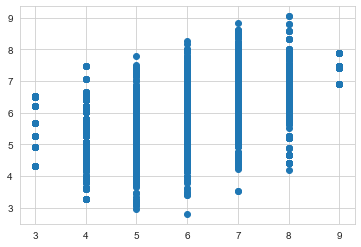

In [130]:
plt.scatter(ym5_test,predictions_m5)

**Residual Histogram**

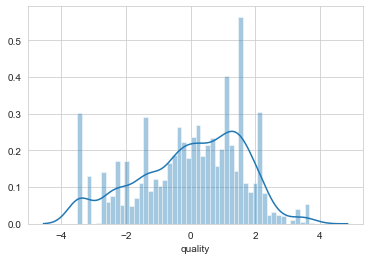

In [131]:
sns.distplot((ym5_test-predictions_m5),bins=50);

In [132]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym5_test, predictions_m5))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym5_test, predictions_m5))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym5_test, predictions_m5)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym5_test, predictions_m5))
print('Explained Variance:', metrics.explained_variance_score(ym5_test, predictions_m5))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym5_test, predictions_m5))
print('Median Absolute Error:', metrics.median_absolute_error(ym5_test, predictions_m5))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym5_test, predictions_m5))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym5_test, predictions_m5))



R-squared: 0.3235383844870585
Mean Squared Error (MSE): 2.6761944920006324
Root Mean Squared Error (RMSE): 1.6359078494831647
Log Mean Squared Error: 0.06878283232583796
Explained Variance: 0.32354047217094073
Mean Absolute Error (MAE): 1.3456437515675395
Median Absolute Error: 1.2501322856947423
Poisson Deviance: 0.48303943519402465
Mean Gamma Deviance: 0.09151312323492732



## Model 6: Drop Residual Sugar



In [133]:
#Create y and X datasets for this model
ym6 = df.quality
Xm6 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar'],axis=1)
#Balance data
ros = RandomOverSampler(random_state=42)
Xm6_resampled, ym6_resampled = ros.fit_resample(Xm6, ym6)
from collections import Counter
print(sorted(Counter(ym6_resampled).items()))

from sklearn.model_selection import train_test_split
Xm6_train, Xm6_test, ym6_train, ym6_test = train_test_split(Xm6_resampled, ym6_resampled, test_size=0.25, random_state=101)
Xm6_train.head()

[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,volatile_acidity,citric_acid,chlorides,pH,sulphates,alcohol
3016,3967,0.27,0.51,0.049,3.16,0.54,9.4
1981,2718,0.28,0.29,0.028,3.24,0.54,10.0
9700,2804,0.22,0.32,0.028,3.13,0.55,10.9
5229,3087,0.20,0.34,0.041,3.14,0.44,10.1
2351,3160,0.34,0.46,0.023,3.15,0.54,12.9


In [134]:
Xm6_train.shape

(9313, 7)

In [135]:
from sklearn.linear_model import LinearRegression
lm6 = LinearRegression()
lm6.fit(Xm6_train,ym6_train)
print('Estimated intercept coefficient:',lm6.intercept_)
print ('Number of coefficients:', len(lm6.coef_))
coeffm6_df = pd.DataFrame(lm6.coef_,Xm6.columns,columns=['Coefficient'])
coeffm6_df


Estimated intercept coefficient: 4.941342229127351
Number of coefficients: 7


,Coefficient
Unnamed: 0,-0.000075
volatile_acidity,-3.145012
citric_acid,-2.031959
chlorides,-45.908579
pH,-1.122124
sulphates,3.440857
alcohol,0.598011


In [136]:
predictions_m6 = lm6.predict(Xm6_test)

**Predicted vs. Actual**

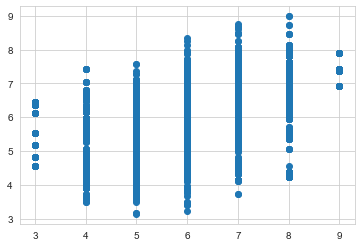

In [137]:
plt.scatter(ym6_test,predictions_m6)

**Residual Histogram**

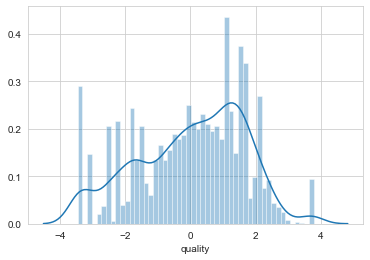

In [138]:
sns.distplot((ym6_test-predictions_m6),bins=50);

In [139]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym6_test, predictions_m6))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym6_test, predictions_m6))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym6_test, predictions_m6)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym6_test, predictions_m6))
print('Explained Variance:', metrics.explained_variance_score(ym6_test, predictions_m6))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym6_test, predictions_m6))
print('Median Absolute Error:', metrics.median_absolute_error(ym6_test, predictions_m6))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym6_test, predictions_m6))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym6_test, predictions_m6))



R-squared: 0.3133628021884647
Mean Squared Error (MSE): 2.7164507854486306
Root Mean Squared Error (RMSE): 1.6481658852945085
Log Mean Squared Error: 0.06966723788881167
Explained Variance: 0.31341018077539895
Mean Absolute Error (MAE): 1.3672692628157759
Median Absolute Error: 1.261213936420825
Poisson Deviance: 0.49195397417341113
Mean Gamma Deviance: 0.09341781062368423


## Model 7: Drop Citric Acid

In [140]:
#Create y and X datasets for this model
ym7 = df.quality
Xm7 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid'],axis=1)
#Balance data
ros = RandomOverSampler(random_state=42)
Xm7_resampled, ym7_resampled = ros.fit_resample(Xm7, ym7)
from collections import Counter
print(sorted(Counter(ym1_resampled).items()))

from sklearn.model_selection import train_test_split
Xm7_train, Xm7_test, ym7_train, ym7_test = train_test_split(Xm7_resampled, ym7_resampled, test_size=0.25, random_state=101)
Xm7_train.head()

[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,volatile_acidity,chlorides,pH,sulphates,alcohol
3016,3967,0.27,0.049,3.16,0.54,9.4
1981,2718,0.28,0.028,3.24,0.54,10.0
9700,2804,0.22,0.028,3.13,0.55,10.9
5229,3087,0.20,0.041,3.14,0.44,10.1
2351,3160,0.34,0.023,3.15,0.54,12.9


In [141]:
Xm7_train.shape

(9313, 6)

In [142]:
from sklearn.linear_model import LinearRegression
lm7 = LinearRegression()
lm7.fit(Xm7_train,ym7_train)
print('Estimated intercept coefficient:',lm7.intercept_)
print ('Number of coefficients:', len(lm7.coef_))
coeffm7_df = pd.DataFrame(lm7.coef_,Xm7.columns,columns=['Coefficient'])
coeffm7_df

Estimated intercept coefficient: 4.513952538989476
Number of coefficients: 6


,Coefficient
Unnamed: 0,-0.000046
volatile_acidity,-2.608699
chlorides,-47.426183
pH,-1.120966
sulphates,3.521496
alcohol,0.558562


In [143]:
predictions_m7 = lm7.predict(Xm7_test)

**Predicted vs. Actual**

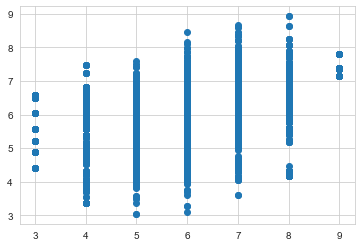

In [144]:
plt.scatter(ym7_test,predictions_m7)

**Residual Histogram**

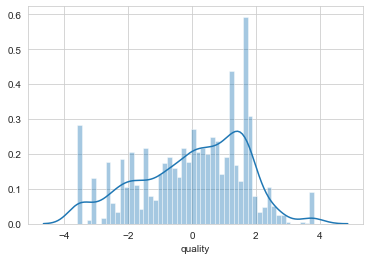

In [145]:
sns.distplot((ym7_test-predictions_m7),bins=50);

In [146]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym7_test, predictions_m7))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym7_test, predictions_m7))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym7_test, predictions_m7)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym7_test, predictions_m7))
print('Explained Variance:', metrics.explained_variance_score(ym7_test, predictions_m7))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym7_test, predictions_m7))
print('Median Absolute Error:', metrics.median_absolute_error(ym7_test, predictions_m7))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym7_test, predictions_m7))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym7_test, predictions_m7))


R-squared: 0.3089867885027562
Mean Squared Error (MSE): 2.7337630223206846
Root Mean Squared Error (RMSE): 1.6534095144037018
Log Mean Squared Error: 0.0701764828742455
Explained Variance: 0.3090271576525989
Mean Absolute Error (MAE): 1.3670470569550113
Median Absolute Error: 1.2582048390595855
Poisson Deviance: 0.49461642054215593
Mean Gamma Deviance: 0.09382129447260515


## Model 8: Drop Alcohol

In [147]:
#Create y and X datasets for this model
ym8 = df.quality
Xm8 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid','alcohol'],axis=1)
#Balance data
ros = RandomOverSampler(random_state=42)
Xm8_resampled, ym8_resampled = ros.fit_resample(Xm8, ym8)
from collections import Counter
print(sorted(Counter(ym8_resampled).items()))

from sklearn.model_selection import train_test_split
Xm8_train, Xm8_test, ym8_train, ym8_test = train_test_split(Xm8_resampled, ym8_resampled, test_size=0.25, random_state=101)
Xm8_train.head()

[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,volatile_acidity,chlorides,pH,sulphates
3016,3967,0.27,0.049,3.16,0.54
1981,2718,0.28,0.028,3.24,0.54
9700,2804,0.22,0.028,3.13,0.55
5229,3087,0.20,0.041,3.14,0.44
2351,3160,0.34,0.023,3.15,0.54


In [148]:
Xm8_train.shape

(9313, 5)

In [149]:
from sklearn.linear_model import LinearRegression
lm8 = LinearRegression()
lm8.fit(Xm8_train,ym8_train)
print('Estimated intercept coefficient:',lm8.intercept_)
print ('Number of coefficients:', len(lm8.coef_))
coeffm8_df = pd.DataFrame(lm8.coef_,Xm8.columns,columns=['Coefficient'])
coeffm8_df

Estimated intercept coefficient: 9.720676824929741
Number of coefficients: 5


,Coefficient
Unnamed: 0,0.000014
volatile_acidity,-1.457054
chlorides,-90.115484
pH,-0.336082
sulphates,2.846086


In [150]:
predictions_m8 = lm8.predict(Xm8_test)

**Predicted vs. Actual**

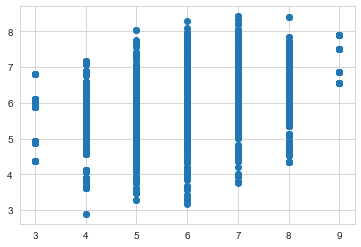

In [151]:
plt.scatter(ym8_test,predictions_m8)

**Residual Histogram**

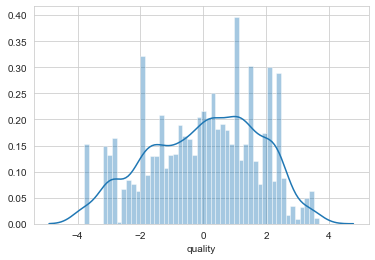

In [152]:
sns.distplot((ym8_test-predictions_m8),bins=50);

In [153]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym8_test, predictions_m8))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym8_test, predictions_m8))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym8_test, predictions_m8)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym8_test, predictions_m8))
print('Explained Variance:', metrics.explained_variance_score(ym8_test, predictions_m8))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym8_test, predictions_m8))
print('Median Absolute Error:', metrics.median_absolute_error(ym8_test, predictions_m8))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym8_test, predictions_m8))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym8_test, predictions_m8))


R-squared: 0.23255205472983675
Mean Squared Error (MSE): 3.03615152276134
Root Mean Squared Error (RMSE): 1.7424556013744912
Log Mean Squared Error: 0.07493976239537709
Explained Variance: 0.23267011580941388
Mean Absolute Error (MAE): 1.4548523767285995
Median Absolute Error: 1.3808429580740338
Poisson Deviance: 0.5394558912921359
Mean Gamma Deviance: 0.10035669478753646


## Model 9: Drop pH

In [154]:
#Create y and X datasets for this model
ym9 = df.quality
Xm9 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid','alcohol','pH'],axis=1)
#Balance data
ros = RandomOverSampler(random_state=42)
Xm9_resampled, ym9_resampled = ros.fit_resample(Xm9, ym9)
from collections import Counter
print(sorted(Counter(ym9_resampled).items()))

from sklearn.model_selection import train_test_split
Xm9_train, Xm9_test, ym9_train, ym9_test = train_test_split(Xm9_resampled, ym9_resampled, test_size=0.25, random_state=101)
Xm9_train.head()

[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,volatile_acidity,chlorides,sulphates
3016,3967,0.27,0.049,0.54
1981,2718,0.28,0.028,0.54
9700,2804,0.22,0.028,0.55
5229,3087,0.20,0.041,0.44
2351,3160,0.34,0.023,0.54


In [155]:
Xm9_train.shape

(9313, 4)

In [156]:
from sklearn.linear_model import LinearRegression
lm9 = LinearRegression()
lm9.fit(Xm9_train,ym9_train)
print('Estimated intercept coefficient:',lm9.intercept_)
print ('Number of coefficients:', len(lm9.coef_))
coeffm9_df = pd.DataFrame(lm9.coef_,Xm9.columns,columns=['Coefficient'])
coeffm9_df


Estimated intercept coefficient: 8.619255239716912
Number of coefficients: 4


,Coefficient
Unnamed: 0,0.000023
volatile_acidity,-1.446825
chlorides,-89.178986
sulphates,2.760131


In [157]:
predictions_m9 = lm9.predict(Xm9_test)

**Predicted vs. Actual**

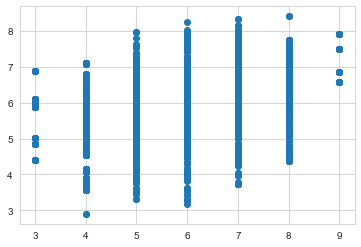

In [158]:
plt.scatter(ym9_test,predictions_m9)

**Residual Histogram**

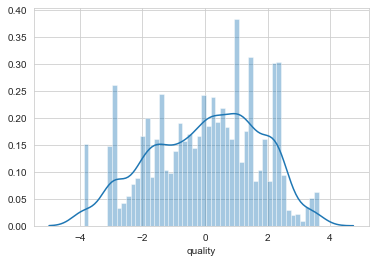

In [159]:
sns.distplot((ym9_test-predictions_m9),bins=50);

In [160]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym9_test, predictions_m9))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym9_test, predictions_m9))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym9_test, predictions_m9)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym9_test, predictions_m9))
print('Explained Variance:', metrics.explained_variance_score(ym9_test, predictions_m9))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym9_test, predictions_m9))
print('Median Absolute Error:', metrics.median_absolute_error(ym9_test, predictions_m9))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym9_test, predictions_m9))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym9_test, predictions_m9))


R-squared: 0.23145073012033746
Mean Squared Error (MSE): 3.0405085458152086
Root Mean Squared Error (RMSE): 1.7437054068320166
Log Mean Squared Error: 0.07520087972163868
Explained Variance: 0.23157977898836013
Mean Absolute Error (MAE): 1.4539854973530637
Median Absolute Error: 1.3929326386235328
Poisson Deviance: 0.5406995504124473
Mean Gamma Deviance: 0.10067421768904102


## Model 10: Drop Sulphates

In [161]:
#Create y and X datasets for this model

ym10 = df.quality
Xm10 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid','alcohol','pH','sulphates'],axis=1)

#Balance data
ros = RandomOverSampler(random_state=42)
Xm10_resampled, ym10_resampled = ros.fit_resample(Xm10, ym10)
from collections import Counter
print(sorted(Counter(ym10_resampled).items()))


from sklearn.model_selection import train_test_split
Xm10_train, Xm10_test, ym10_train, ym10_test = train_test_split(Xm10_resampled, ym10_resampled, test_size=0.25, random_state=101)
Xm10_train.head()


[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,volatile_acidity,chlorides
3016,3967,0.27,0.049
1981,2718,0.28,0.028
9700,2804,0.22,0.028
5229,3087,0.20,0.041
2351,3160,0.34,0.023


In [162]:
Xm10_train.shape

(9313, 3)

In [163]:
from sklearn.linear_model import LinearRegression
lm10 = LinearRegression()
lm10.fit(Xm10_train,ym10_train)
print('Estimated intercept coefficient:',lm10.intercept_)
print ('Number of coefficients:', len(lm10.coef_))
coeffm10_df = pd.DataFrame(lm10.coef_,Xm10.columns,columns=['Coefficient'])
coeffm10_df

Estimated intercept coefficient: 9.836495535983701
Number of coefficients: 3


,Coefficient
Unnamed: 0,0.000017
volatile_acidity,-1.497430
chlorides,-86.810815


In [164]:
predictions_m10 = lm10.predict(Xm10_test)

**Predicted vs. Actual**

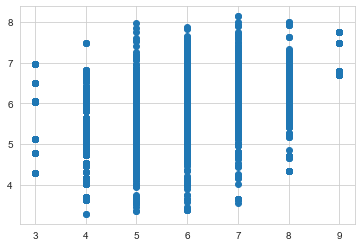

In [165]:
plt.scatter(ym10_test,predictions_m10)

**Residual Histogram**

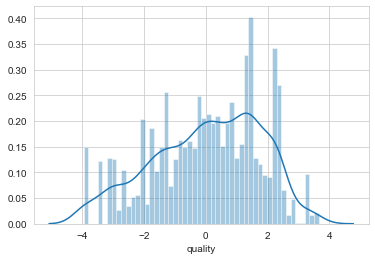

In [166]:
sns.distplot((ym10_test-predictions_m10),bins=50);

In [167]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym10_test, predictions_m10))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym10_test, predictions_m10))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym10_test, predictions_m10)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym10_test, predictions_m10))
print('Explained Variance:', metrics.explained_variance_score(ym10_test, predictions_m10))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym10_test, predictions_m10))
print('Median Absolute Error:', metrics.median_absolute_error(ym10_test, predictions_m10))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym10_test, predictions_m10))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym10_test, predictions_m10))


R-squared: 0.21998941606088818
Mean Squared Error (MSE): 3.085851407632622
Root Mean Squared Error (RMSE): 1.7566591609167164
Log Mean Squared Error: 0.0763385772760167
Explained Variance: 0.22012849929823164
Mean Absolute Error (MAE): 1.4580044235477942
Median Absolute Error: 1.340265601053627
Poisson Deviance: 0.5457414233723202
Mean Gamma Deviance: 0.10103674734289224


## Model 11: Drop Volatile Activity

In [168]:
#Create y and X datasets for this model
ym11 = df.quality
Xm11 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid','alcohol','pH','sulphates','volatile_acidity'],axis=1)

#Balance data
ros = RandomOverSampler(random_state=42)
Xm11_resampled, ym11_resampled = ros.fit_resample(Xm11, ym11)
from collections import Counter
print(sorted(Counter(ym11_resampled).items()))


from sklearn.model_selection import train_test_split
Xm11_train, Xm11_test, ym11_train, ym11_test = train_test_split(Xm11_resampled, ym11_resampled, test_size=0.25, random_state=101)
Xm11_train.head()


[(3, 1774), (4, 1774), (5, 1774), (6, 1774), (7, 1774), (8, 1774), (9, 1774)]


,Unnamed: 0,chlorides
3016,3967,0.049
1981,2718,0.028
9700,2804,0.028
5229,3087,0.041
2351,3160,0.023


In [169]:
Xm11_train.shape

(9313, 2)

In [170]:
from sklearn.linear_model import LinearRegression
lm11 = LinearRegression()
lm11.fit(Xm11_train,ym11_train)
print('Estimated intercept coefficient:',lm11.intercept_)
print ('Number of coefficients:', len(lm11.coef_))
coeffm11_df = pd.DataFrame(lm11.coef_,Xm11.columns,columns=['Coefficient'])
coeffm11_df

Estimated intercept coefficient: 9.361633717299458
Number of coefficients: 2


,Coefficient
Unnamed: 0,0.000024
chlorides,-85.572211


In [171]:
predictions_m11 = lm11.predict(Xm11_test)

**Predicted vs. Actual**

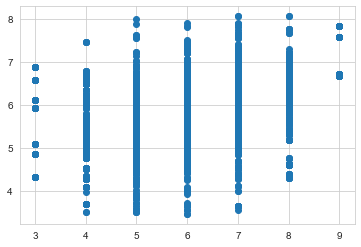

In [172]:
plt.scatter(ym11_test,predictions_m11)

**Residual Histogram**

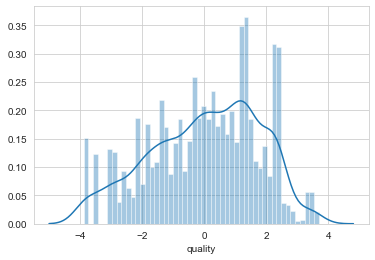

In [173]:
sns.distplot((ym11_test-predictions_m11),bins=50);

In [174]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym11_test, predictions_m11))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym11_test, predictions_m11))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym11_test, predictions_m11)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym11_test, predictions_m11))
print('Explained Variance:', metrics.explained_variance_score(ym11_test, predictions_m11))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym11_test, predictions_m11))
print('Median Absolute Error:', metrics.median_absolute_error(ym11_test, predictions_m11))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym11_test, predictions_m11))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym11_test, predictions_m11))


R-squared: 0.2165468288884661
Mean Squared Error (MSE): 3.0994708542025236
Root Mean Squared Error (RMSE): 1.76053141244413
Log Mean Squared Error: 0.07673537822208619
Explained Variance: 0.21669608707461774
Mean Absolute Error (MAE): 1.4630105569088594
Median Absolute Error: 1.3197172505599228
Poisson Deviance: 0.5491744490162322
Mean Gamma Deviance: 0.10178119505470495
